# Kernel density estimation
Different ways of calculating and plotting:  
https://stackoverflow.com/questions/30145957/plotting-2d-kernel-density-estimation-with-python  
https://stackoverflow.com/questions/41577705/how-does-2d-kernel-density-estimation-in-python-sklearn-work

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(42)

In [2]:
# Edinburgh
from data_processing import read_edinburgh_data 
data, agent_ids = read_edinburgh_data()

/Users/kriis/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


reading:./OpenTraj/datasets/Edinburgh/annotations/tracks.01Sep.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2342/2342 [01:02<00:00, 37.62it/s]


Warning! too big dt in [Edinburgh]
finish


In [12]:
def agent_data(data, agent_id):
    x = data["pos_x"].loc[data["agent_id"]==agent_id].values
    y = data["pos_y"].loc[data["agent_id"]==agent_id].values

    max_train_idx = len(x)-5
    
    return x, y, max_train_idx

# Sample train and test data for pos_x and pos_y, each slice with num_steps length
def generate_data(data, begin_idx, agent_id, num_steps=5):
    sample_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values
    sample_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx:begin_idx+num_steps].values

    test_x = data["pos_x"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    test_y = data["pos_y"].loc[data["agent_id"]==agent_id][begin_idx+num_steps:begin_idx+2*num_steps].values
    
    return sample_x, sample_y, test_x, test_y
    
def calculate_FDE(pred_x, pred_y, test_x, test_y):

    final_displacement_x = pred_x[-1] - test_x[-1]
    final_displacement_y = pred_y[-1] - test_y[-1]
    FDE = np.sqrt(final_displacement_x**2 + final_displacement_y**2)
    
    return FDE

### Plotting

In [175]:
def plot_whole_trajectories(sample_x, sample_y, cluster_avg_x, cluster_avg_y, no_of_clusters, weights):
    plt.axes().set_aspect('equal')
        
    plt.plot(sample_x, sample_y, color='g', linewidth=2)
    plt.scatter(sample_x, sample_y, color='g', linewidth=2)

    for i in range(no_of_clusters):
        plt.plot(cluster_avg_x[i], cluster_avg_y[i])
        plt.scatter(cluster_avg_x[i][:-1], cluster_avg_y[i][:-1])
        plt.scatter(cluster_avg_x[i][-1], cluster_avg_y[i][-1], linewidth=15*weights[i])
        plt.annotate(weights[i], (cluster_avg_x[i][-1], cluster_avg_y[i][-1]))

    plt.scatter(sample_x[0], sample_y[0], color='b')

    plt.show()
    
def plot_predictions(sample_x, sample_y, test_x, test_y, xx, yy, f):
    plt.figure(figsize=(10, 10))
    plt.axes().set_aspect('equal')
    
    CS = plt.contour(xx, yy, f, levels=[0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56])
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.plot(sample_x, sample_y)
    plt.scatter(sample_x, sample_y)
    
    plt.scatter(test_x, test_y)
    plt.plot(np.append(sample_x[-1], test_x), np.append(sample_y[-1],test_y), '--')
    plt.show()

### Estimation methods

In [142]:
def avg_vel_const(sample_x, sample_y, noise_var):
    sample_vel_x = [(sample_x[i] - sample_x[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [(sample_y[i] - sample_y[i-1]) + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    avg_vel_x = np.mean(sample_vel_x)
    avg_vel_y = np.mean(sample_vel_y)
    
    pred_x = [sample_x[-1] + i*avg_vel_x for i in range(1, 6)]
    pred_y = [sample_y[-1] + i*avg_vel_y for i in range(1, 6)]
    
    return pred_x, pred_y

def avg_acc_const(sample_x, sample_y, noise_var):
    sample_vel_x = [sample_x[i] - sample_x[i-1] + np.random.normal(0, noise_var) for i in range(1, len(sample_x))]
    sample_vel_y = [sample_y[i] - sample_y[i-1] + np.random.normal(0, noise_var) for i in range(1, len(sample_y))]
    
    sample_acceleration_x = [sample_vel_x[i] - sample_vel_x[i-1] for i in range(1, len(sample_vel_x))]
    sample_acceleration_y = [sample_vel_y[i] - sample_vel_y[i-1] for i in range(1, len(sample_vel_y))]
    
    avg_acceleration_x = np.mean(sample_acceleration_x)
    avg_acceleration_y = np.mean(sample_acceleration_y)

    last_vel_x = sample_vel_x[-1]
    last_vel_y = sample_vel_y[-1]
    
    pred_x = [sample_x[-1] + last_vel_x + avg_acceleration_x]
    pred_y = [sample_y[-1] + last_vel_y + avg_acceleration_y]
    for i in range(1, 5):
        pred_x.append(pred_x[i-1] + last_vel_x + i * avg_acceleration_x)
        pred_y.append(pred_y[i-1] + last_vel_y + i * avg_acceleration_y)
        
    return pred_x, pred_y

## Experiments

### Avg vel as const

In [173]:
import scipy.stats as st

def avg_vel_const_w_noise(data, agent_id, plotting=False):
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    final_points = []
    all_final_x = []
    all_final_y = []
    for i in range(1000):
        pred_x, pred_y = avg_vel_const(sample_x, sample_y, 0.1)
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
        final_points.append([pred_x[-1], pred_y[-1]])

    all_final_x = np.array(all_final_x)
    all_final_y = np.array(all_final_y)
    
    
    
    xmin, xmax = min(all_final_x), max(all_final_x)
    ymin, ymax = min(all_final_y), max(all_final_y)
    
    xdiff = xmax - xmin
    ydiff = ymax - ymin
    
    xmin = xmin - xdiff
    xmax = xmax + xdiff
    
    ymin = ymin - ydiff
    ymax = ymax + ydiff
    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    print(f.shape)
    
    if plotting:
        plot_predictions(sample_x, sample_y, test_x, test_y, xx, yy, f)

(300, 300)


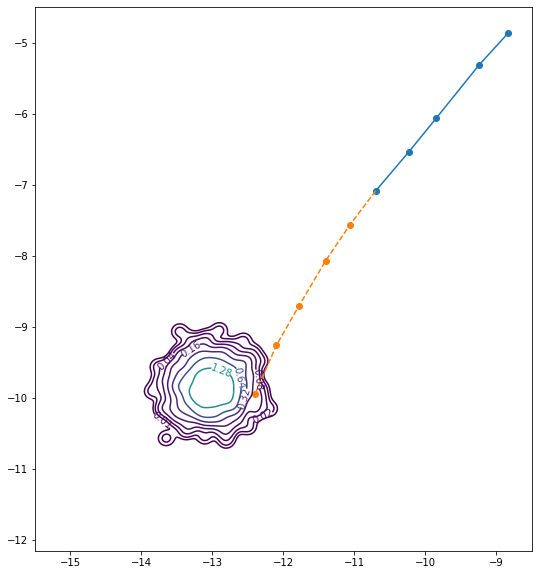

(300, 300)


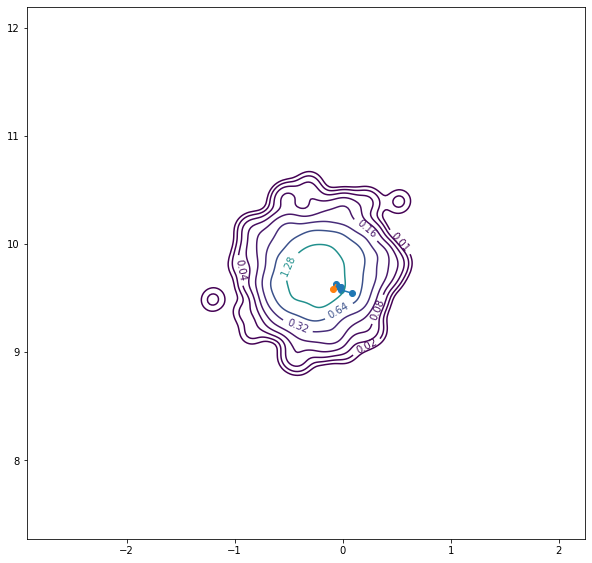

(300, 300)


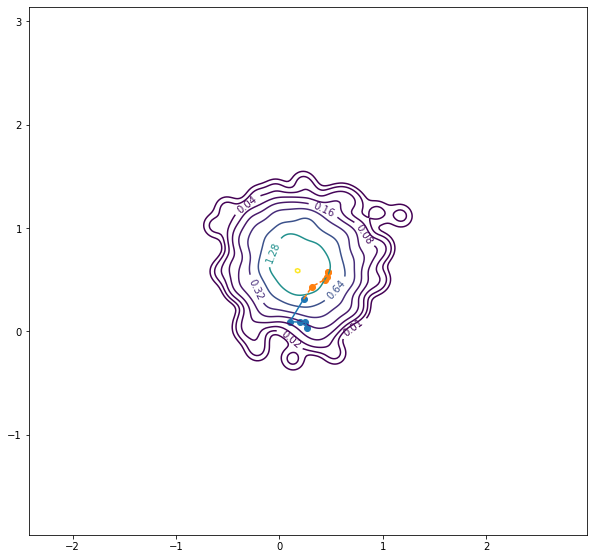

(300, 300)


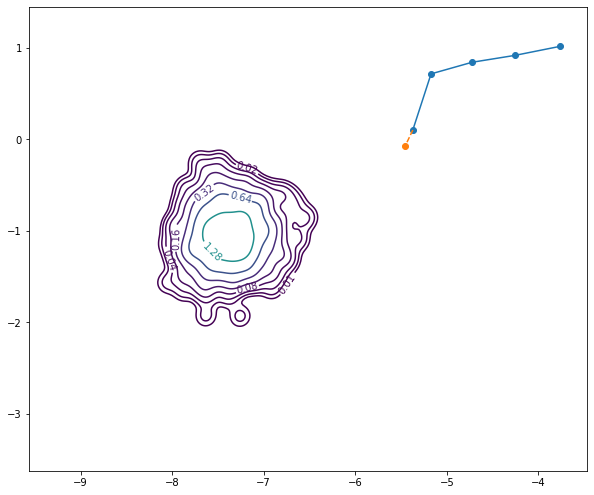

(300, 300)


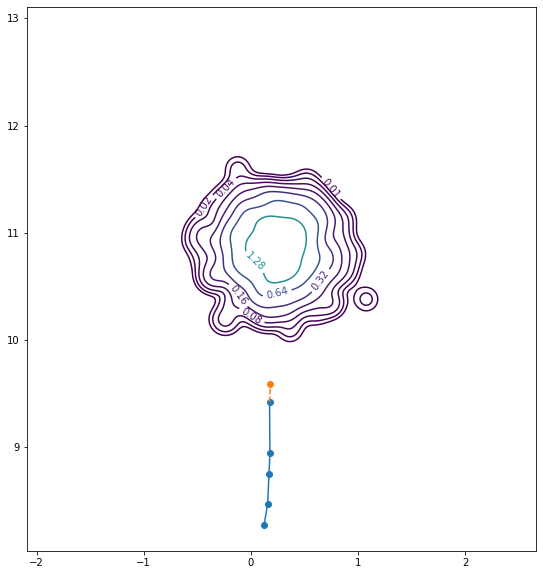

(300, 300)


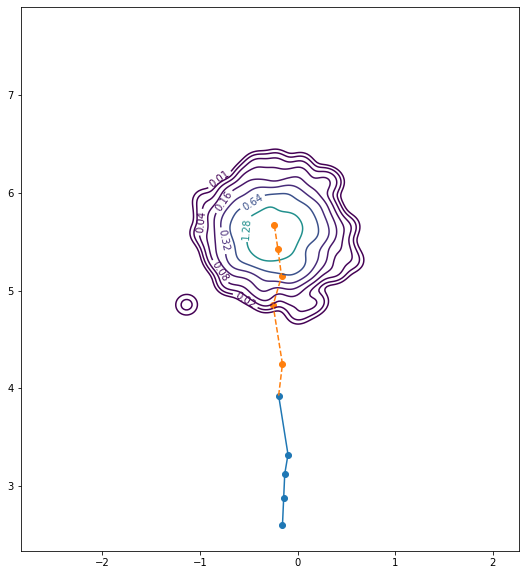

(300, 300)


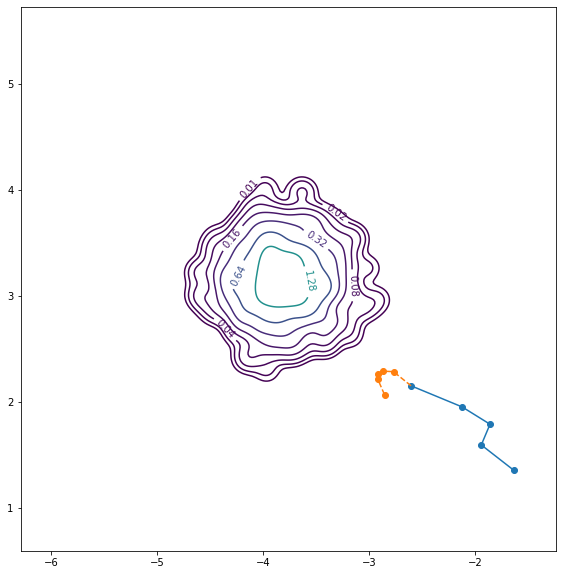

(300, 300)


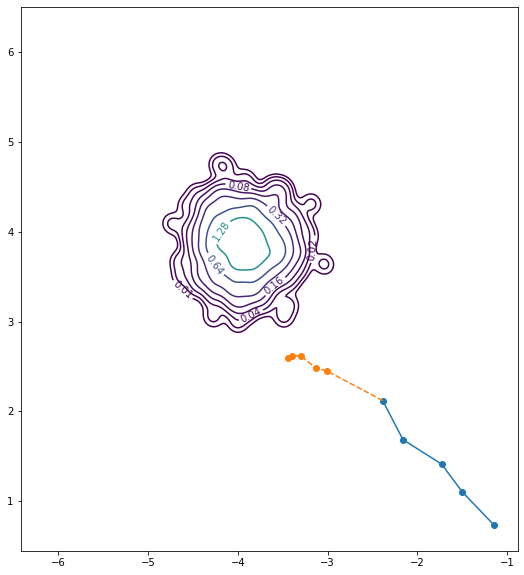

(300, 300)


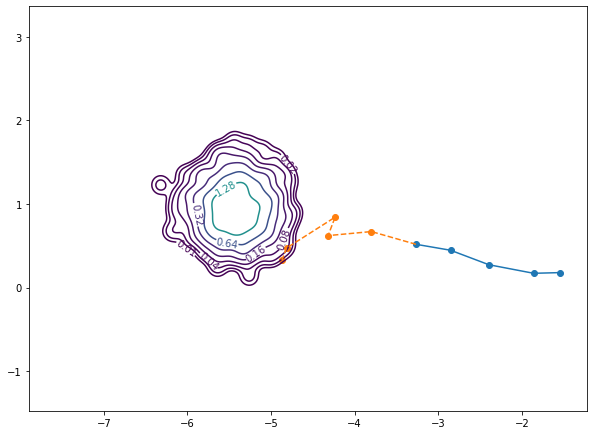

(300, 300)


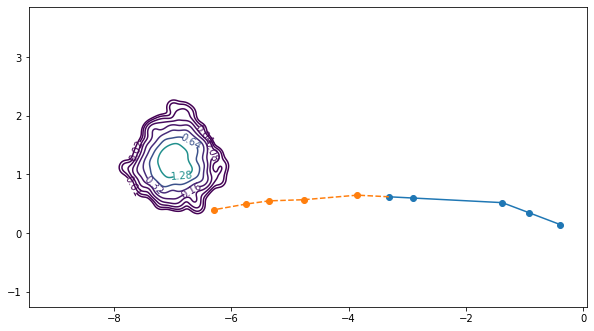

(300, 300)


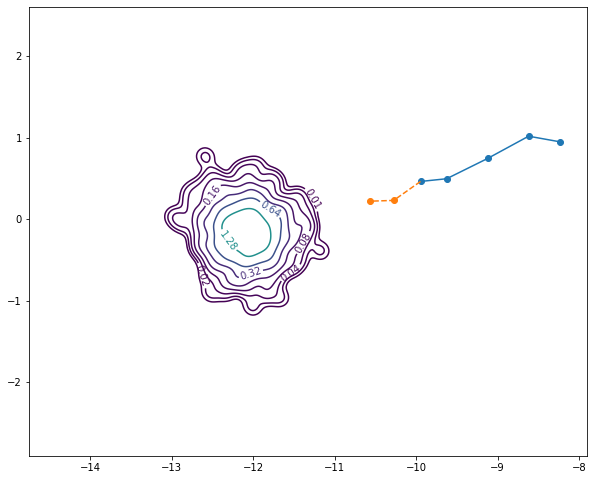

(300, 300)


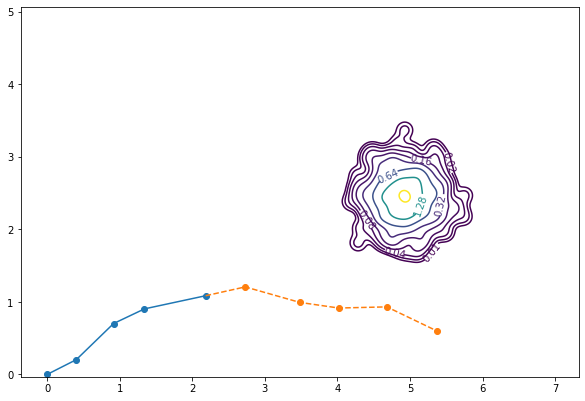

(300, 300)


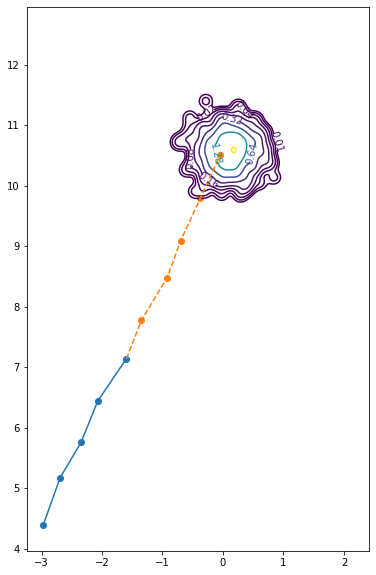

(300, 300)


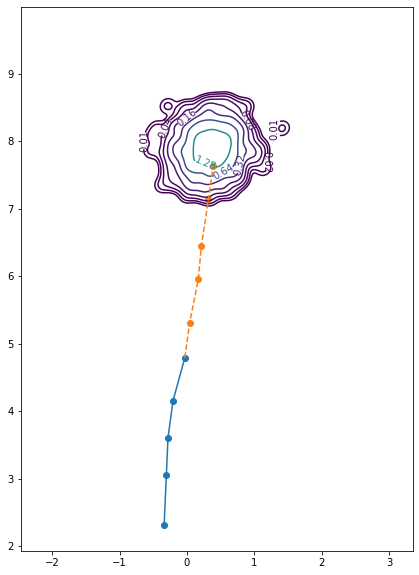

(300, 300)


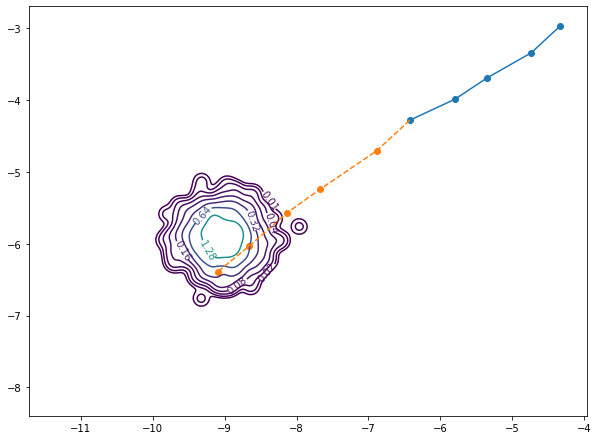

(300, 300)


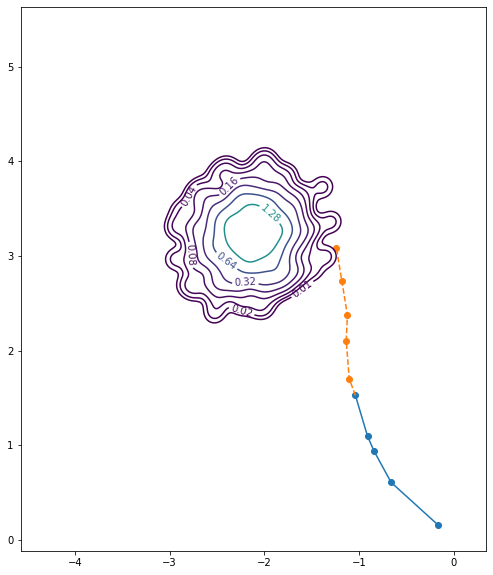

(300, 300)


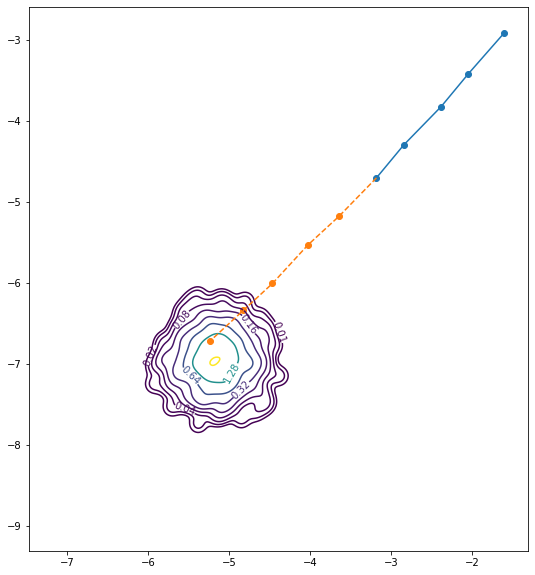

(300, 300)


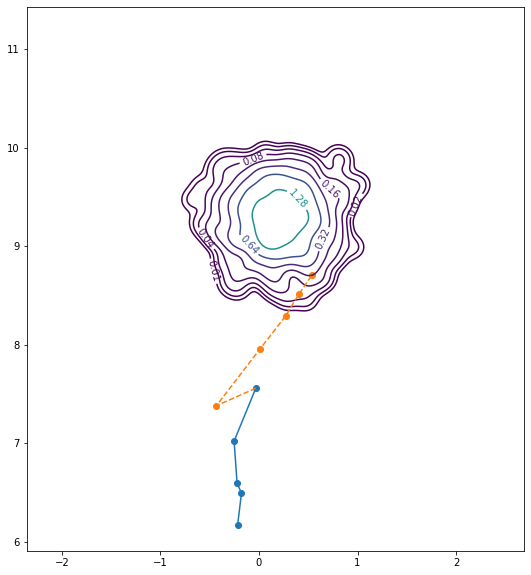

(300, 300)


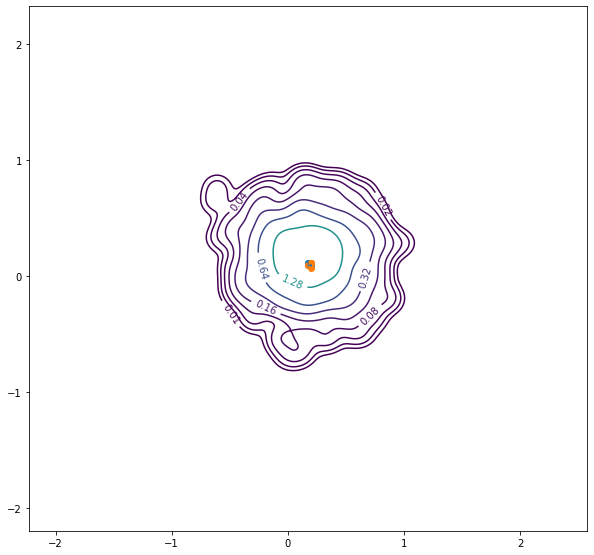

(300, 300)


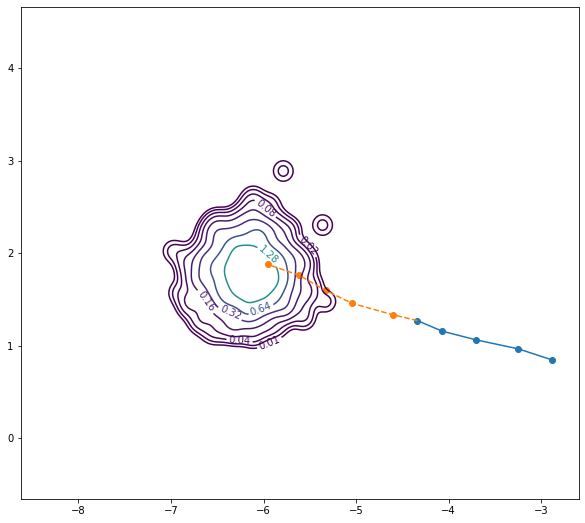

(300, 300)


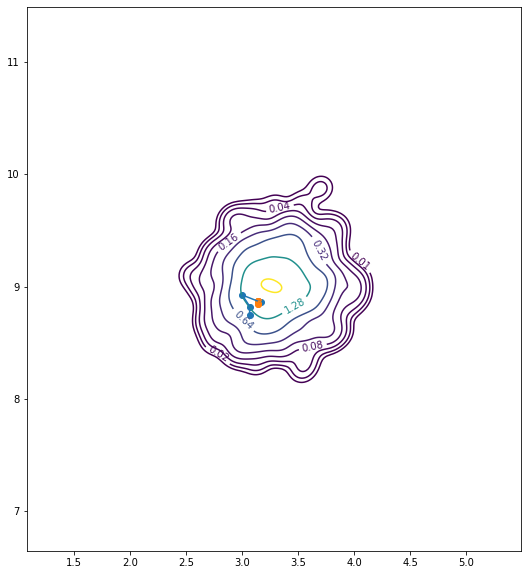

(300, 300)


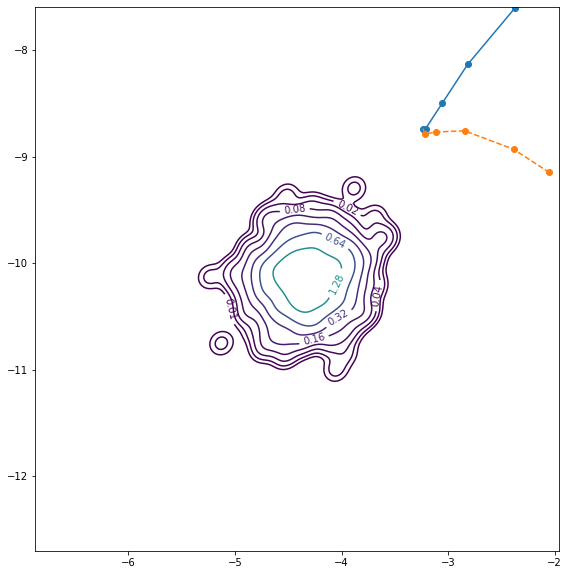

(300, 300)


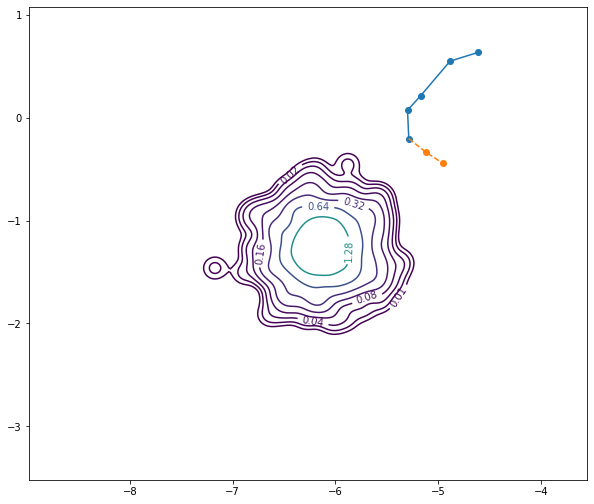

(300, 300)


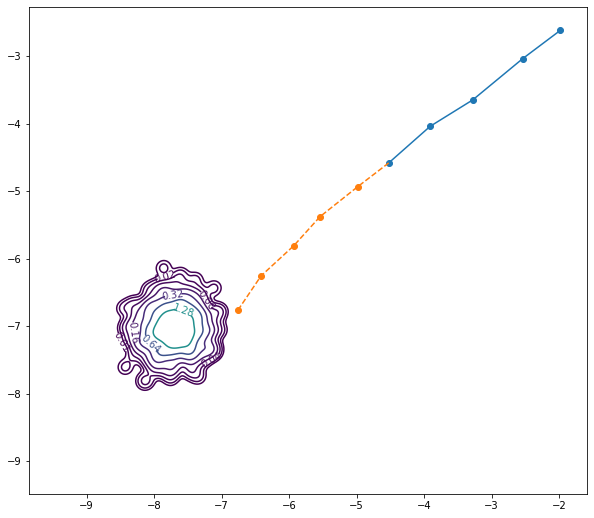

(300, 300)


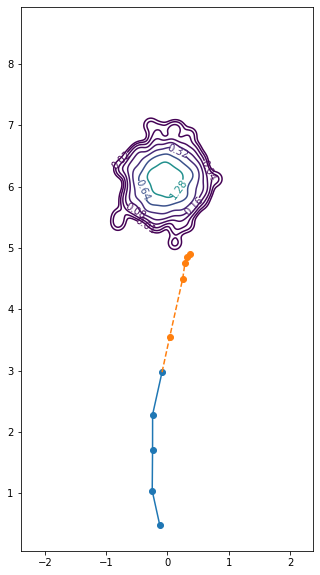

(300, 300)


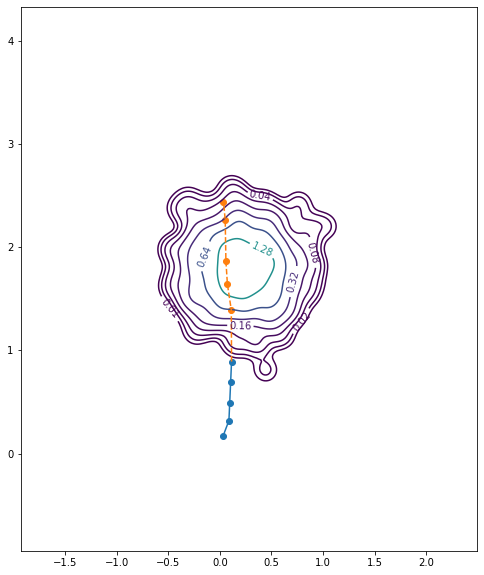

(300, 300)


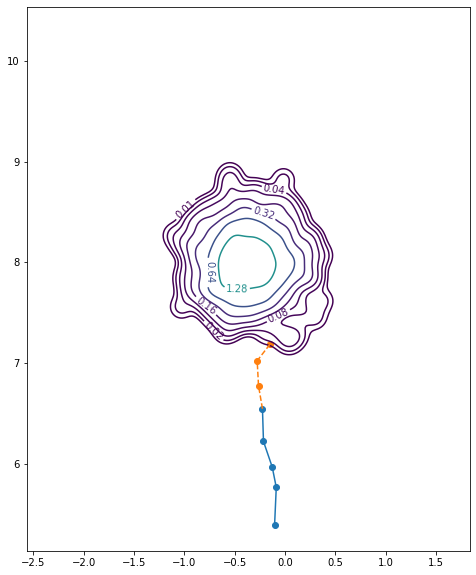

(300, 300)


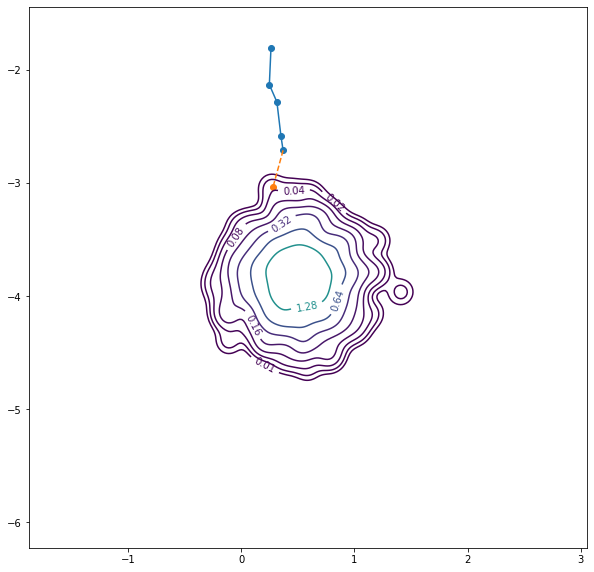

(300, 300)


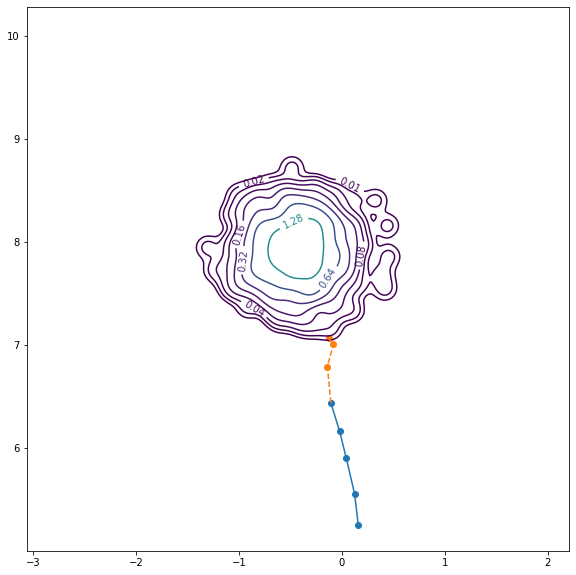

(300, 300)


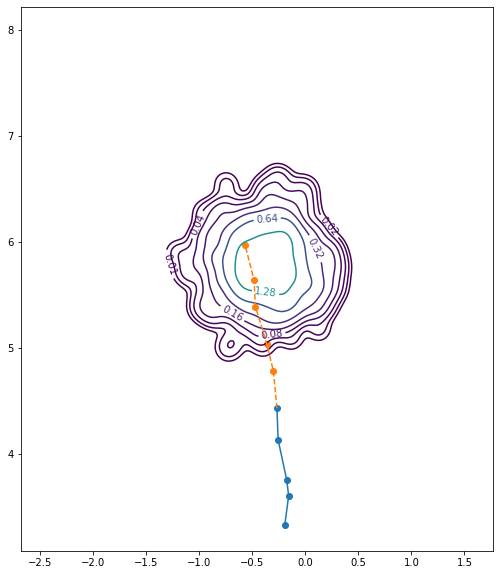

In [178]:
for i in agent_ids[:30]:
    avg_vel_const_w_noise(data, i, plotting=True)

### Avg acc as const

In [152]:
import scipy.stats as st

def avg_acc_const_w_noise(data, agent_id, plotting=False):
    x_data, y_data, max_train_idx = agent_data(data, agent_id)
    random_start_idx = np.random.randint(0, max_train_idx)
    sample_x, sample_y, test_x, test_y = generate_data(data, random_start_idx, agent_id, 5)
    
    final_points = []
    all_final_x = []
    all_final_y = []
    for i in range(1000):
        pred_x, pred_y = avg_acc_const(sample_x, sample_y, 0.1)
        all_final_x.append(pred_x[-1])
        all_final_y.append(pred_y[-1])
        final_points.append([pred_x[-1], pred_y[-1]])
    #print(all_final_x)

    all_final_x = np.array(all_final_x)
    all_final_y = np.array(all_final_y)
    
    xmin, xmax = min(all_final_x), max(all_final_x)
    ymin, ymax = min(all_final_y), max(all_final_y)
    
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([all_final_x, all_final_y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    if plotting:
        plot_predictions(sample_x, sample_y, test_x, test_y, xx, yy, f)

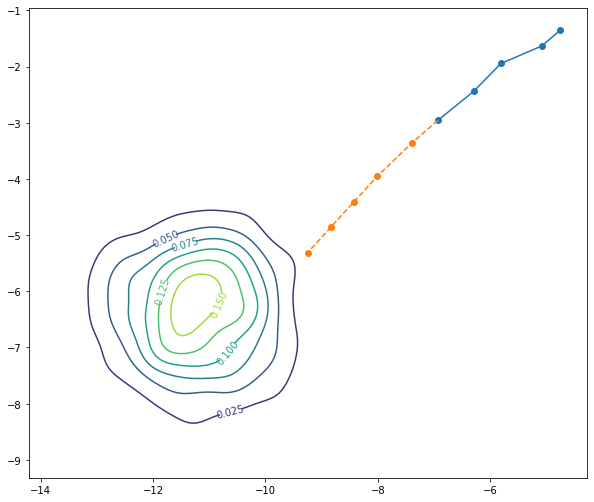

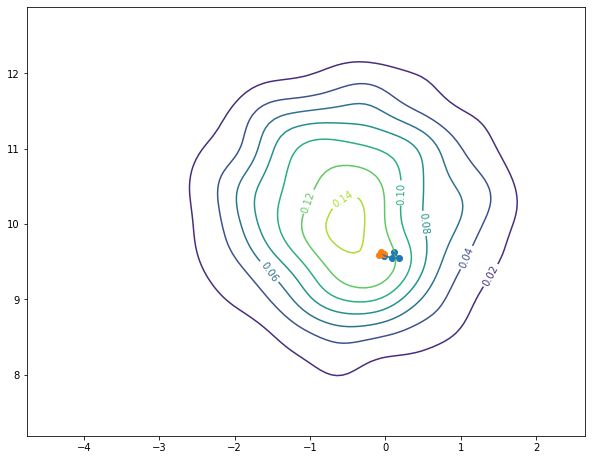

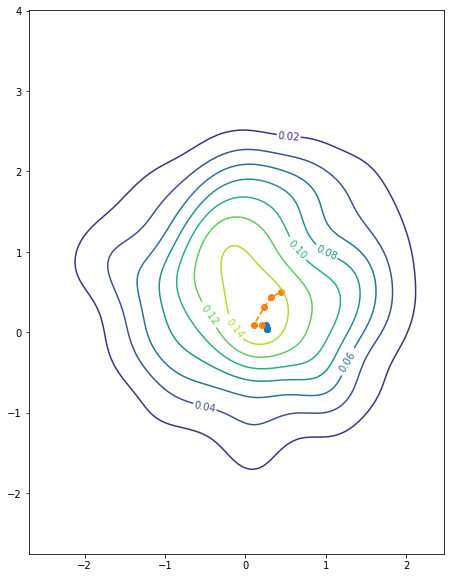

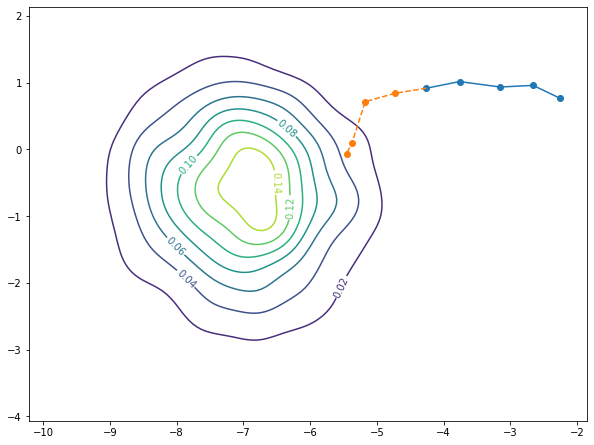

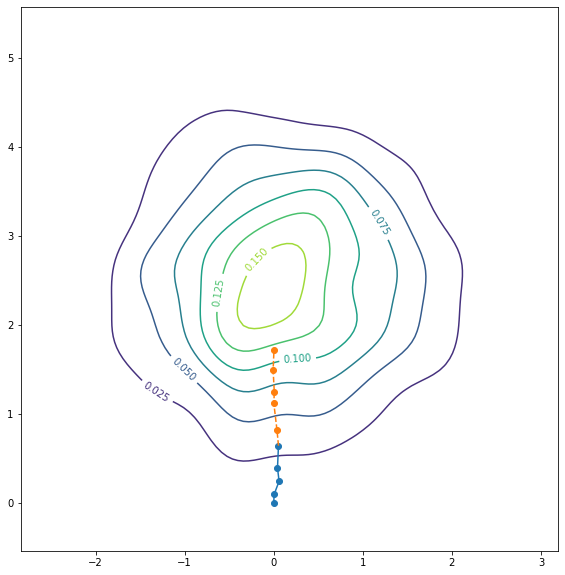

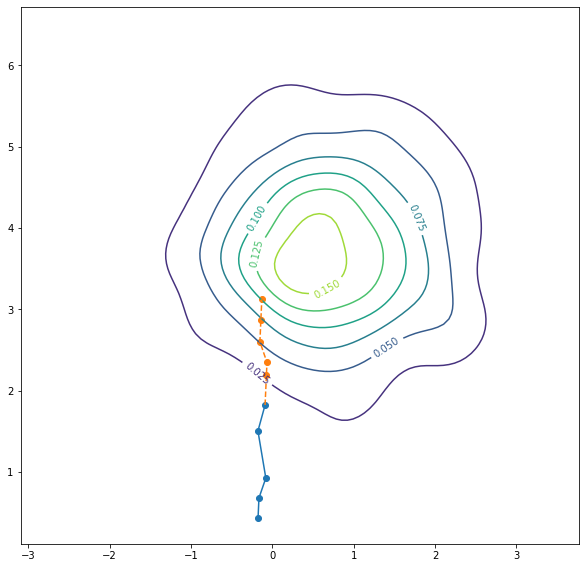

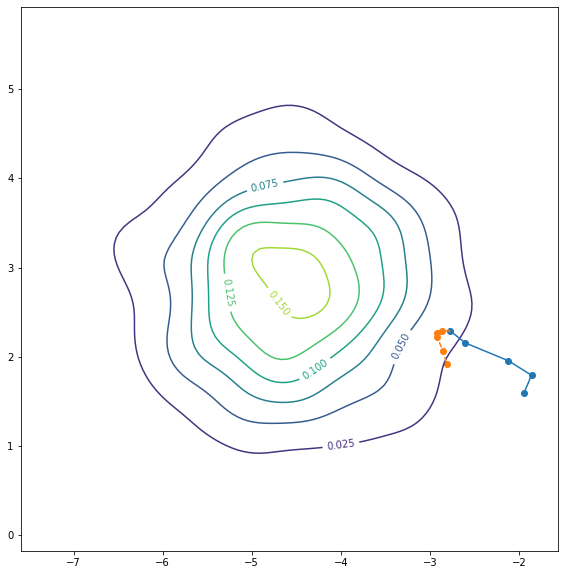

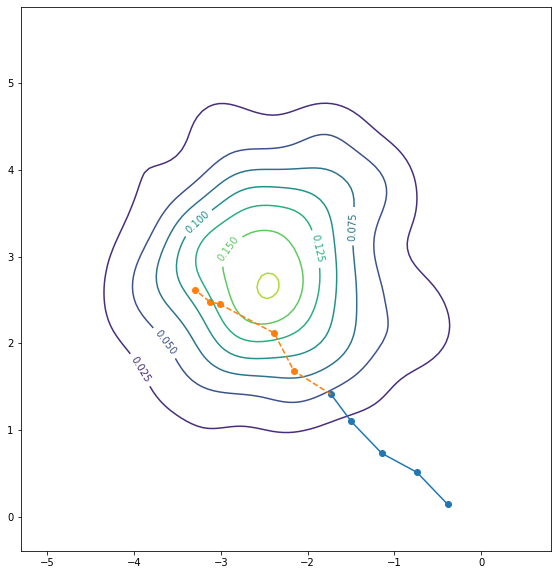

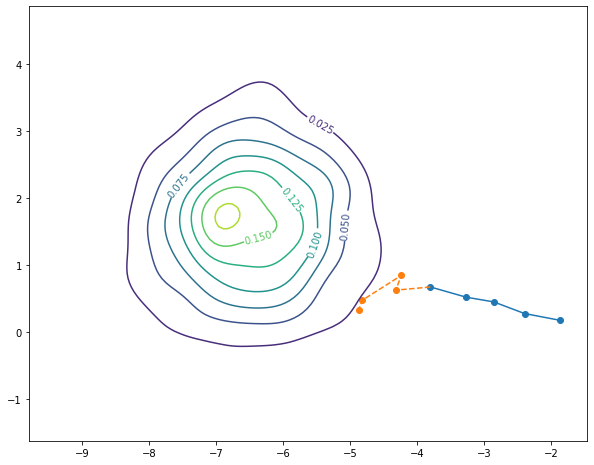

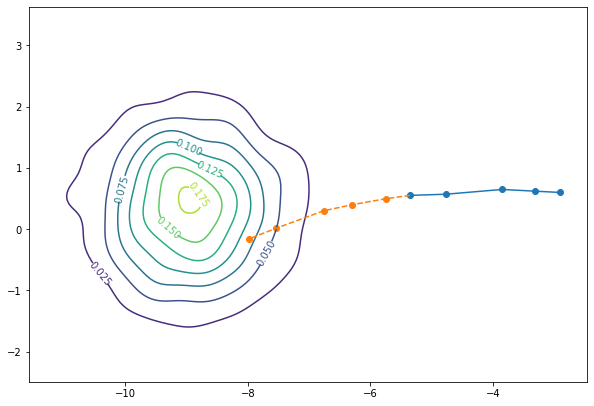

In [153]:
for i in agent_ids[:10]:
    avg_acc_const_w_noise(data, i, plotting=True)
    